#### Requirements

1. Librosa > ! pip install librosa

In [168]:
import librosa
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from keras.layers import Conv1D,Dropout,MaxPooling1D,Flatten,Dense


In [123]:
# getting list of files in directory E:\\My_Projects\\ai_projects\\speech_emotion_recognizer\\Dataset\\Emo_DB\\wav
filepath = 'E:\\My_Projects\\ai_projects\\speech_emotion_recognizer\\Dataset\\Emo_DB\\wav'
file_list = os.listdir(filepath)

##### Audio File information

Every utterance is named according to the same scheme:<br><br>

Positions 1-2: number of speaker<br>
Positions 3-5: code for text<br>
Position 6: emotion (sorry, letter stands for german emotion word)<br>
Position 7: if there are more than two versions these are numbered a, b, c ....<br>
Example: 03a01Fa.wav is the audio file from Speaker 03 speaking text a01 with the emotion "Freude" (Happiness).<br>

Information about the speakers<br>
03 - male, 31 years old<br>
08 - female, 34 years<br>
09 - female, 21 years<br>
10 - male, 32 years<br>
11 - male, 26 years<br>
12 - male, 30 years<br>
13 - female, 32 years<br>
14 - female, 35 years<br>
15 - male, 25 years<br>
16 - female, 31 years<br>


Code of emotions:


|letter    |	emotion |(english) letter |emotion (german)|
|:--------:|:----------:|:---------------:|:--------------:|
|A	 |anger  |		W	|           	Ärger (Wut)|
|B	|boredom|		L	|  		Langeweile|
|D	|disgust|		E	|		Ekel|
|F	|anxiety/fear|	A	|		Angst|
|H	|happiness|	F		|	Freude|
|S	|sadness|		T	|		Trauer|
N = neutral version




##### an example file

In [124]:
file_list[0] ## a file name

'03a01Fa.wav'

 03a01Fa.wav is the audio file from Speaker 03 speaking text a01 with the emotion "Freude" (Happiness).

### All file dataframe

In [125]:
df = pd.DataFrame(zip(file_list,[re.findall(r'\w(?=\w\.)',x)[0] for x in file_list]),columns=['filename','Emotion'])

Text(0.5, 1.0, 'FRequency plot of emotions')

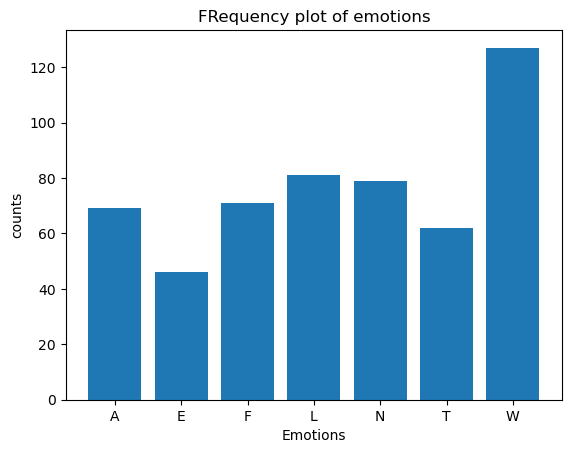

In [126]:
values, counts = np.unique(df['Emotion'], return_counts=True) ## Frequency plot of emotions 
plt.bar(values,counts)
plt.xlabel('Emotions')
plt.ylabel('counts')
plt.title('FRequency plot of emotions')

#### Getting information about wavefrom

In [127]:
## y-> waveform,  sr -> sample rate
y=[]
sr=[]
for file in file_list:
    yi, sri = librosa.load(filepath+'\\'+file)
    y.append(yi)
    sr.append(sri)
# y = np.asarray(y,dtype=object)
# sr = np.asarray(sr,dtype=object)
#print("shape for y",y.shape)

In [128]:
print("Sample rate is ",sr[445],"samples per second")

Sample rate is  22050 samples per second


In [129]:
labels = df['Emotion'].replace({'A':0,'W':1,'L':2,'T':3,'E':4,'F':5,'N':6})

## Explanatory Data Analysis

##### Audio data visualizations for audio file 03a01Fa.wav

In [130]:
emotions = ["Happiness(F)",
            "Neutral(N)",
            "Anger(W)",
            "Anxiety/Fear(A)",
            "Boredom(L)",
            "Disgust(T)",
            "Sadness(E)"]
emo_file_list = [0,1,2,8,10,5,310]

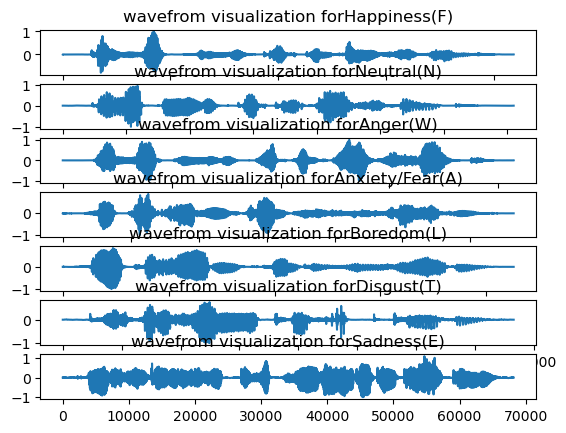

In [131]:
figure ,axes = plt.subplots(7)
for ind,val in enumerate(emo_file_list):    
    axes[ind].plot(range(0,y[val].shape[0]),y[val])
    axes[ind].set_title("wavefrom visualization for"+emotions[ind])
    


##### HPSS plot

what is harmonic sound?<br>

what is percusive sound?

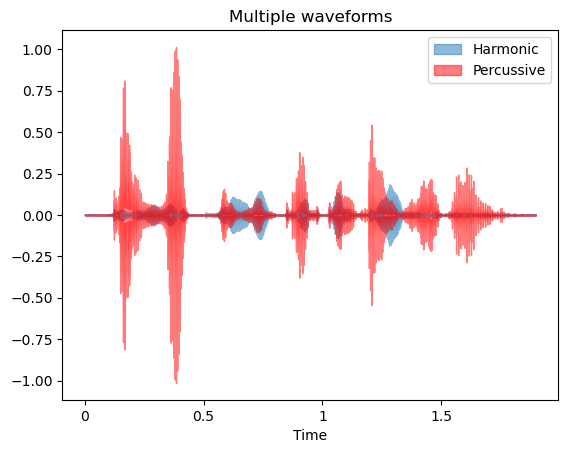

In [132]:
fig, ax = plt.subplots(sharex=True)
y_harm, y_perc = librosa.effects.hpss(y[0])
librosa.display.waveshow(y_harm, sr=sr[0], alpha=0.5, ax=ax, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr[0], color='r', alpha=0.5, ax=ax, label='Percussive')
ax.set(title='Multiple waveforms')
ax.legend()

In [133]:
df = pd.DataFrame(zip(file_list,[re.findall(r'\w(?=\w\.)',x)[0] for x in file_list],y,sr),columns=['filename','Emotion','waveform','sampling rate'])

#### Getting short time fourier transform(STFT)

The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

In [134]:
stft = librosa.stft(y[0])
print(stft.shape)

(1025, 82)


##### Getting spectogram for audio instance 

C:\Users\cnctk\AppData\Local\Temp\ipykernel_16668\2446546785.py:1: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft)


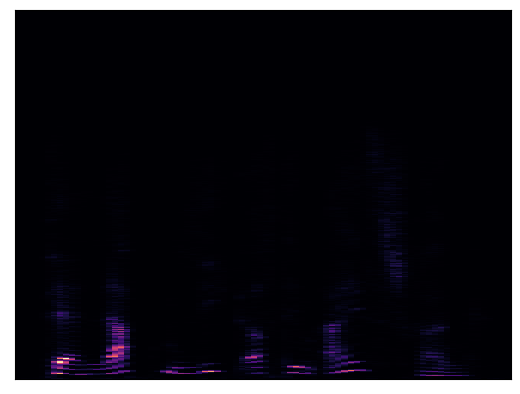

In [135]:
librosa.display.specshow(stft)

## Feature Extraction

1800 seconds * 8000hz = 14400000 samples <br>
hop length= it is no of samples a window is moved with each step.<br>
how many hops you can fit depends on whether you pad somehow or not<br>
if we decide not to pad the number of frames also depends on your window size.<br>

if we take how many samples are 10 ms?<br>
if 1 s = 8000 samples (i.e 8000hz)<br>
samples in 0.01s == 8000*0.01 = 80 samples <br>

i.e hop length of 80 samples and a window length of 160 samples (0.02s- twice as long)<br>

22050 samples in 1 s
smaples in 25ms = 22050*0.01

Here we are taking no. of frames as 25 ms 

In [136]:
### n_samples = frame_len*sample_rate
n_samples = 25 * 0.001 * sr[0]
print("no of samples",n_samples)

no of samples 551.25


#### Extracting MFCC features from 535 audio files

Also deriving 1st order and 2nd order features from mfcc

In [137]:
mfcc = []
delta_mfcc = []
delta2_mfcc =[]

for i in range(df.shape[0]):
    a  = librosa.feature.mfcc(y=y[i], sr=sr[i], hop_length=int(n_samples), n_mfcc=20) # creating mfcc features
    a = np.resize(a,(13,250))
    mfcc.append(a) 
    delta_mfcc.append(librosa.feature.delta(mfcc[i]))              # creating 1st order deravative of mfcc
    delta2_mfcc.append(librosa.feature.delta(mfcc[i], order=2)) # creating 1st order deravative of mfcc
    

##### Plotting MFCC features and corresponding Spectograms

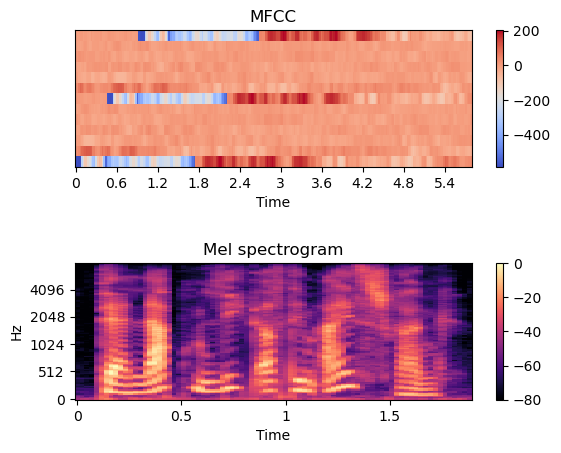

In [138]:
fig ,ax = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.7, wspace=0.5)

img = librosa.display.specshow(mfcc[0], x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='MFCC')

S = librosa.feature.melspectrogram(y=y[0], sr=sr[0], n_mels=128,fmax=8000)
mfcc_db = librosa.feature.mfcc(S=librosa.power_to_db(S))
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='Mel spectrogram')
ax[1].label_outer()

In [139]:
mfcc = np.array(mfcc)
delta_mfcc = np.array(delta_mfcc)
delta2_mfcc = np.array(delta2_mfcc)

In [140]:
print(mfcc.shape,delta_mfcc.shape,delta2_mfcc.shape)

(535, 13, 250) (535, 13, 250) (535, 13, 250)


In [141]:
mfcc_prefinal =  np.hstack((mfcc,delta_mfcc,delta2_mfcc))

In [142]:
mfcc_prefinal.shape

(535, 39, 250)

### Time domian features derived from mfcc features

###### Defining bin 

In [143]:
binsize = 4
mfcct =[]
for j in range(len(mfcc)):
    bins = mfcc[j].shape[0]/binsize  # no. of rows/binsize
    n_time_features = 12
    mfv = np.zeros((n_time_features*int(bins),mfcc[j].shape[1]))
    mfv.shape
    for k in range(mfcc[j].shape[1]):
        initial =1
        phai = 1
        for l in range(1,int(bins)+1):
            m = mfcc[j][initial-1:l*binsize,k]
            
            c = np.array([np.min(m),np.max(m),np.mean(m),int(stats.mode(m)[0]),np.median(m),np.var(m),
                          np.std(m),np.cov(m),np.sqrt(np.mean(m**2)),np.percentile(m,25),
                          np.percentile(m,50),np.percentile(m,75)])
        
            for p in range(12,0,-1):
                mfv[phai+n_time_features-p-1,k] = c[p-1]
                
            initial = initial+binsize
            phai = phai+n_time_features
    mfcct.append(mfv)
                

C:\Users\cnctk\AppData\Local\Temp\ipykernel_16668\1202758693.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  c = np.array([np.min(m),np.max(m),np.mean(m),int(stats.mode(m)[0]),np.median(m),np.var(m),


In [144]:
mfcct=np.array(mfcct)

In [145]:
mfcc_final = np.hstack((mfcc_prefinal,mfcct))

In [156]:
mfcc_prefinal = np.hstack((mfcc_prefinal,mfcct))

In [161]:
mfcc_prefinal.shape

(535, 75, 250)

In [164]:
reshaped = np.reshape(mfcc_prefinal,(535,-1))

In [166]:
reshaped[1]

array([-544.73608398, -524.10083008, -547.36651611, ...,  -34.16891479,
        -17.36220169,  -13.36737061])

mfcct_m = []
for i in range(df.shape[0]):
    mfcct_m.append(np.mean(mfcct[i].T,axis=0))
    
mfcc_final = np.column_stack((mfcc_prefinal,mfcct_m))    

mfcc_final = mfcc_final.reshape(mfcc_final.shape[0], mfcc_final.shape[1], 1)
print(mfcc_final.shape)

#### splitting train test 

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)


In [147]:
labels = keras.utils.to_categorical(labels)

## Creating Convolutional Model

### Convolutional layer architecture

In [175]:
inputs = keras.Input(shape=(reshaped.shape[1],1))

conv_layer1 = Conv1D(64,kernel_size=5,strides=1,activation ='relu',padding='same',kernel_initializer="he_uniform")(inputs)
drop_layer1 = Dropout(0.2)(conv_layer1)
maxpool_layer1 = MaxPooling1D(4)(drop_layer1)

conv_layer2 = Conv1D(128,kernel_size=5,strides=1,activation ='relu',padding='same',kernel_initializer="he_uniform")(maxpool_layer1)
drop_layer2 = Dropout(0.2)(conv_layer2)
maxpool_layer2 = MaxPooling1D(4)(drop_layer2)

conv_layer3 = Conv1D(256,kernel_size=5,strides=1,activation ='relu',padding='same',kernel_initializer="he_uniform")(maxpool_layer2)
drop_layer3 = Dropout(0.2)(conv_layer3)
maxpool_layer3 = MaxPooling1D(4)(drop_layer3)

flatten_layer = Flatten()(maxpool_layer3)
outputs = Dense(7,activation='softmax')(flatten_layer)




model = keras.Model(inputs=inputs,outputs=outputs)

In [176]:
print(model.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 18750, 1)]        0         
                                                                 
 conv1d_7 (Conv1D)           (None, 18750, 64)         384       
                                                                 
 dropout_24 (Dropout)        (None, 18750, 64)         0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 4687, 64)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 4687, 128)         41088     
                                                                 
 dropout_25 (Dropout)        (None, 4687, 128)         0         
                                                           

In [177]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='CategoricalCrossentropy',metrics=['accuracy'])

In [178]:
model.fit(reshaped,labels, epochs=100,batch_size = 16, validation_split = 0.2)

Epoch 1/100
27/27 [==============================] - 34s 1s/step - loss: 33030.4883 - accuracy: 0.2150 - val_loss: 892.4130 - val_accuracy: 0.2617
Epoch 2/100
27/27 [==============================] - 35s 1s/step - loss: 789.8065 - accuracy: 0.2827 - val_loss: 204.0368 - val_accuracy: 0.2150
Epoch 3/100
27/27 [==============================] - 36s 1s/step - loss: 319.6850 - accuracy: 0.2921 - val_loss: 84.6062 - val_accuracy: 0.1776
Epoch 4/100
27/27 [==============================] - 36s 1s/step - loss: 171.9709 - accuracy: 0.3178 - val_loss: 46.4992 - val_accuracy: 0.2430
Epoch 5/100
27/27 [==============================] - 36s 1s/step - loss: 125.6009 - accuracy: 0.3458 - val_loss: 41.4606 - val_accuracy: 0.2804
Epoch 6/100
27/27 [==============================] - 37s 1s/step - loss: 96.7986 - accuracy: 0.3762 - val_loss: 46.7208 - val_accuracy: 0.2617
Epoch 7/100
27/27 [==============================] - 36s 1s/step - loss: 72.0294 - accuracy: 0.3902 - val_loss: 35.5093 - val_accurac

27/27 [==============================] - 40s 2s/step - loss: 3.2486 - accuracy: 0.8224 - val_loss: 11.4985 - val_accuracy: 0.3645
Epoch 59/100
27/27 [==============================] - 45s 2s/step - loss: 2.6799 - accuracy: 0.8248 - val_loss: 17.6956 - val_accuracy: 0.3551
Epoch 60/100
27/27 [==============================] - 54s 2s/step - loss: 2.5474 - accuracy: 0.8014 - val_loss: 13.9210 - val_accuracy: 0.3458
Epoch 61/100
27/27 [==============================] - 48s 2s/step - loss: 1.9602 - accuracy: 0.8201 - val_loss: 13.1882 - val_accuracy: 0.3458
Epoch 62/100
27/27 [==============================] - 48s 2s/step - loss: 1.9726 - accuracy: 0.8084 - val_loss: 14.2793 - val_accuracy: 0.3271
Epoch 63/100
27/27 [==============================] - 44s 2s/step - loss: 2.2275 - accuracy: 0.8341 - val_loss: 11.1786 - val_accuracy: 0.3178
Epoch 64/100
27/27 [==============================] - 46s 2s/step - loss: 2.7655 - accuracy: 0.8271 - val_loss: 11.6016 - val_accuracy: 0.3271
Epoch 65/100

#### Results